# Water Observations from Space (WOfS) for flow percentiles

This notebook creates an interactive hydrograph that is used to return WOfS images.

Daily streamflow information and stream gauge coordinates are retrieved directly from the Bureau of Meteorology (BoM) Hydrologic Reference Stations (HRS) website, http://www.bom.gov.au/water/hrs/. The date of streamflow measurement and date of avaliable satellite imagery are matched, for the location of the gauge. A flow duration curve plot is created and the user can specify a percentile range of interest. 

A image is created that shows the percentage of time that water is present (or absent) around the stream gauge, during the specified percentile range of interest. 

"###" indicates fields that require user modification

In [38]:
#Import libraries
%pylab notebook

import datacube 
from datacube import Datacube
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube.storage.storage import write_dataset_to_netcdf
from datacube.helpers import ga_pq_fuser

import xarray as xr
import pandas as pd
import numpy as np
import datetime
import csv
import os

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets

import rasterio
from pyproj import Proj, transform
import urllib
from dateutil import tz
from_zone = tz.tzutc()
to_zone = tz.tzlocal()
dc = datacube.Datacube(app='dc-show changes in annual mean NDVI values')
dcwofs = Datacube(config='/g/data/r78/ext547/wofscube.conf')

Populating the interactive namespace from numpy and matplotlib


## Retrieve stream data and coordinates from the BoM website
The URL for the data is set using the gauge_of_interest

In [39]:
#Specify stream gauge of interest.

###Enter the ID code for the gauge of interest. ID code can be viewed on http://www.bom.gov.au/water/hrs/
###e.g. for 'Diamantina River at Birdsville' the ID code is 'A0020101'

gauge_of_interest= 'G9030250'

In [40]:
#Url is used to retrieve daily streamflow data for the gauge_of_interest    
url = 'http://www.bom.gov.au/water/hrs/content/data/'+gauge_of_interest+'/'+gauge_of_interest+'_daily_ts.csv'
gaugedata = pd.read_csv(url, comment='#')
print (gaugedata)

             Date     Flow (ML) Bureau QCode
0      1966-08-13     10.290800            E
1      1966-08-14     10.009100            E
2      1966-08-15      9.956920            E
3      1966-08-16      9.579110            E
4      1966-08-17      9.292170            E
5      1966-08-18      9.196090            E
6      1966-08-19      9.297820            E
7      1966-08-20      9.863880            E
8      1966-08-21      6.381870            E
9      1966-08-22      4.254020            E
10     1966-08-23      3.432010            E
11     1966-08-24      3.303020            E
12     1966-08-25      3.264020            E
13     1966-08-26      3.299020            E
14     1966-08-27      3.275020            E
15     1966-08-28      3.240020            E
16     1966-08-29      3.239020            E
17     1966-08-30      3.120980            E
18     1966-08-31      2.600010            E
19     1966-09-01      1.805000            E
20     1966-09-02      1.603010            E
21     196

In [41]:
#Url is used to retrieve stream gauge location coordinates. Coordinates are reprojected to Australian Albers   

#Search url to find coordinates 
txt = urllib.request.urlopen(url).read()
txt = str(txt)
sg_lon = txt.split('"Location:", ')[1].split(',"degrees E",')[0]
sg_lon=float(sg_lon)
sg_lat = txt.split(',"degrees E", ')[1].split(',"degrees S"')[0]
sg_lat= "-"+sg_lat
sg_lat=float(sg_lat)

#Reproject
inProj = Proj(init='EPSG:4326')
outProj = Proj(init='EPSG:3577')
sg_x,sg_y = transform(inProj,outProj,sg_lon,sg_lat)

print ("Geographic: " + str(sg_lon)+', '+ str(sg_lat))
print ("Australian Albers: "+ str(sg_x)+', '+str(sg_y))

Geographic: 134.4197, -14.6953
Australian Albers: 263136.9744314623, -1560666.1358515057


## Complete Datacube query

In [76]:
#Spatiotemporal range and wavelengths/band of interest are defined

#Define temporal range
start_of_epoch = '1987-01-01'
end_of_epoch =  '2014-12-31'

#Define wavelengths/bands of interest
bands_of_interest = ['green',
                     'red', 
                     'nir',
                     'swir1']

#Define sensors of interest
sensors = ['ls8',
    'ls7',
    'ls5' ] 

#Create bounding box around the location of the stream gauge
lat_max = sg_lat + 0.05
lat_min = sg_lat - 0.05
lon_max = sg_lon + 0.05
lon_min = sg_lon - 0.05

#Create query
query = {'time': (start_of_epoch, end_of_epoch)}
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [43]:
#Create cloud mask. This will define which pixel quality (PQ) artefacts are removed from the results.

mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

## Complete Datacube extraction
The extracted data is first filtered using the criteria in "mask_components". The cloudiness of the scenes is then tested, and any scenes that do not meet the given "cloud_threshold" are discarded. 

In [44]:
#Retrieve the data for each Landsat sensor

sensor_clean = {}
cloud_threshold = 0.90  ###User requirement: set cloud threshold. Default value is "0.90" or >90% image and <10% cloud cover
                        ###Scenes will not be retrieved that have less than the cloud threshold worth of image.

for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', 
                          measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', 
                        fuse_func=ga_pq_fuser, **query)
    
    #Retrieve the projection information before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    
    #Ensure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    
    #Apply the PQ masks to the NBAR
    quality_mask = masking.make_mask(sensor_pq, **mask_components)
    good_data = quality_mask.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar2 = sensor_nbar.where(good_data)
    
    #Calculate the percentage cloud free for each scene
    cloud_free = masking.make_mask(sensor_pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', 
                                   contiguous=True).pixelquality
    mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_threshold
        
    #Discard data that does not meet the cloud_threshold
    mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', how='all')
    mostly_good['product'] = ('time', numpy.repeat(sensor, mostly_good.time.size))    
    sensor_clean[sensor] = mostly_good

    print('loaded %s' % sensor) 
    

print ('complete')

loaded ls8
loaded ls7
loaded ls5
complete


In [45]:
#Check the output

sensor_clean

{'ls5': <xarray.Dataset>
 Dimensions:  (time: 246, x: 445, y: 447)
 Coordinates:
   * time     (time) datetime64[ns] 1987-05-25T00:29:06.500000 ...
   * y        (y) float64 -1.555e+06 -1.555e+06 -1.555e+06 -1.555e+06 ...
   * x        (x) float64 2.576e+05 2.576e+05 2.576e+05 2.577e+05 2.577e+05 ...
 Data variables:
     green    (time, y, x) float64 797.0 750.0 797.0 844.0 797.0 891.0 844.0 ...
     red      (time, y, x) float64 880.0 837.0 922.0 964.0 1.006e+03 ...
     nir      (time, y, x) float64 2.112e+03 2.164e+03 2.217e+03 2.269e+03 ...
     swir1    (time, y, x) float64 2.472e+03 2.472e+03 2.472e+03 2.509e+03 ...
     product  (time) <U3 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' ...
 Attributes:
     crs:      EPSG:3577, 'ls7': <xarray.Dataset>
 Dimensions:  (time: 48, x: 445, y: 447)
 Coordinates:
   * time     (time) datetime64[ns] 1999-07-21T00:57:50 ...
   * y        (y) float64 -1.555e+06 -1.555e+06 -1.555e+06 -1.555e+06 ...
   * x        (x) float64 2.576e+05 2.57

In [46]:
#Concatenate (join) data from different sensors together and sort so that observations are sorted 
#by time rather than sensor

nbar_clean = xr.concat(sensor_clean.values(), dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affin|e'] = affine

In [47]:
# Check whether the concatenation worked
nbar_clean

<xarray.Dataset>
Dimensions:  (time: 318, x: 445, y: 447)
Coordinates:
  * y        (y) float64 -1.555e+06 -1.555e+06 -1.555e+06 -1.555e+06 ...
  * x        (x) float64 2.576e+05 2.576e+05 2.576e+05 2.577e+05 2.577e+05 ...
  * time     (time) datetime64[ns] 1987-05-25T00:29:06.500000 ...
Data variables:
    green    (time, y, x) float64 797.0 750.0 797.0 844.0 797.0 891.0 844.0 ...
    red      (time, y, x) float64 880.0 837.0 922.0 964.0 1.006e+03 ...
    nir      (time, y, x) float64 2.112e+03 2.164e+03 2.217e+03 2.269e+03 ...
    swir1    (time, y, x) float64 2.472e+03 2.472e+03 2.472e+03 2.509e+03 ...
    product  (time) <U3 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' ...
Attributes:
    crs:      EPSG:3577
    affin|e:  | 25.00, 0.00, 257575.00|\n| 0.00,-25.00,-1555075.00|\n| 0.00, ...

## Process stream gauge information
Calculate the percentiles of stream flow, and sort the dataframe according to date

In [48]:
#Calculate "percentage exceedance" (perexc) for stream flow values

all_data = gaugedata #Import streamflow data from the gauge of interest
all_data= all_data.rename(columns={'Flow (ML)':'flow', 'Date':'date'})  #Rename flow and date columns
all_data = all_data.sort_values('flow', ascending=[False]) #Sort data by flow value
all_data['ranks'] = np.arange(len(all_data)) + 1 #Create rank column and values
all_data['perexc'] = 100*(all_data['ranks'])/(len(all_data)+1) #Calculate probability of each rank
all_data= all_data.sort_values(['date']) #Sort data by date
all_data=all_data.drop(all_data.columns[[2]], axis=1) #Remove "Bureau QCode" column
all_data['date']=pd.to_datetime(all_data['date'], format='%Y/%m/%d %H:%M:%S') #Change datetime format
all_data.date = all_data.date.map(lambda t: t.strftime('%Y-%m-%d')) #Change datetime format

## Return just the time and sensor product information from the Datacube extraction

In [49]:
product_time = nbar_clean[['time', 'product']].to_dataframe() #Add time and product to dataframe
product_time.index = product_time.index + pd.Timedelta(hours=10) #Roughly convert to local time
product_time.index = product_time.index.map(lambda t: t.strftime('%Y-%m-%d')) #Remove Hours/Minutes Seconds by formatting into a string

## Match the date of stream flow data to the date where satellite information exists¶

In [90]:
subset_data = pd.merge(all_data, product_time, left_on= 'date', 
                       right_index=True, how='inner') #Match dates and merge

In [91]:
subset_data['date']=pd.to_datetime(subset_data['date'], format='%Y/%m/%d %H:%M:%S') #Change datetime format

# Create flow duration curve (FDC)

In [52]:
#Prepare flow and percentage exceedance variables for plotting on FDC

#Preapre all data
sorted_a_flow=sorted(all_data.flow, reverse=True)
sorted_a_pe=sorted(all_data.perexc)

#Prepare the matched subset data
sorted_s_flow=sorted(subset_data.flow, reverse=True)
sorted_s_pe=sorted(subset_data.perexc)

<IPython.core.display.Javascript object>


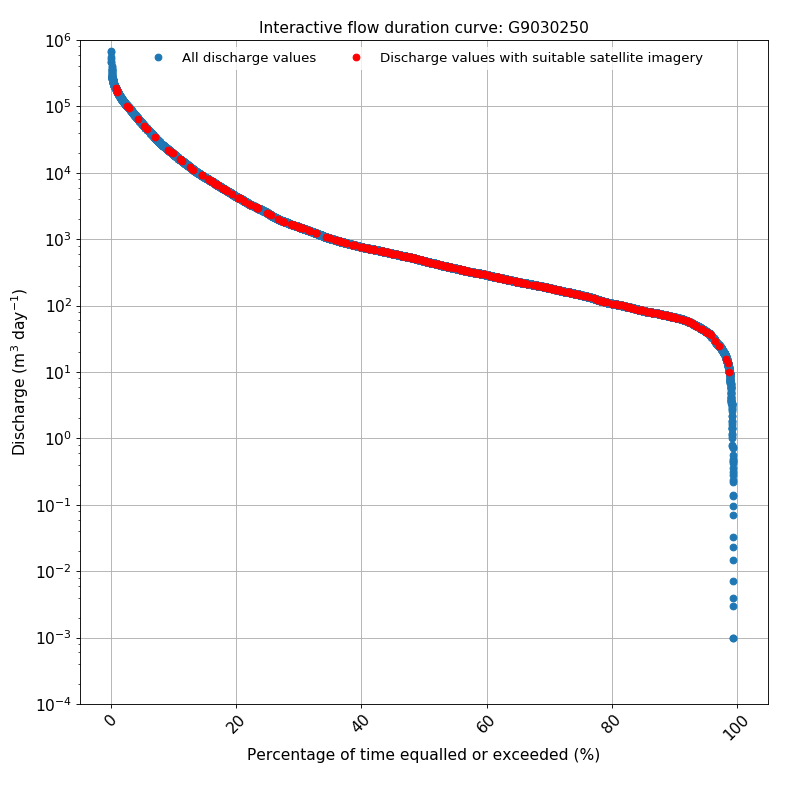

In [53]:
##creation of flow duration curve. Please note that this graph is not interactive

#Plot details
fig = plt.figure(figsize=(10,10)) #Edit size of plot ###User should format as required
plt.title('Interactive flow duration curve: '+gauge_of_interest, size=14) #Plot title ###User should format if required
plt.grid(True) #Add gridlines to the figure
pyplot.yscale('log') #set up Y axis as a log scale
plt.subplots_adjust(left=0.10, right=0.96, top=0.95, bottom=0.12) #Set border dimensions  ###User should format if required
fig.patch.set_facecolor('white')  #Make border white ###User should format if required
fig.patch.set_alpha(0.99)  #Make border white ###User should format if required

#create plot of percent exceedance
plt.plot(sorted_a_pe,sorted_a_flow,'o',label= 'All discharge values')  #plot all discharge values ###User should format series if required
plt.plot(sorted_s_pe,sorted_s_flow,'ro',label='Discharge values with suitable satellite imagery') #plot matched discharge values ###User should format series if required

#axis and legend details
plt.axis([-5, 105, 0.0001, 1000000]) ### User requirement: set axis values for 
plt.xticks(rotation=45,size=14) #Rotate and format size of date labels ###User should format if required
plt.yticks(size=14) #Rotate and format size of date labels ###User should format if required
plt.ylabel('Discharge (m$^3$ day$^{-1}$)', size=14) #Set Y label
plt.xlabel('Percentage of time equalled or exceeded (%)', size=14) #Set X label
plt.legend(edgecolor ='none', ncol=2, loc=9, fontsize=12) ##Set legend location on plot #Make border white ###User should format if required

plt.show() #Show plot

In [54]:
# #Save figure
# ###User requirement: enter directory to save figure
# %cd /g/data/r78/ext547/Output/FDC/ 
# plt.savefig('FDC_'+gauge_of_interest+'_1pct_CFI.jpg') ###User should format if required

# Creation of WOfS imagery

In [77]:
#Create Datacube query for WOfS event of interest

#EITHER... Create a large bounding box around the location of the stream gauge... 
###User requirement: change area of interest to suit gauge location in relation to satellite pass
# lat_max = sg_lat + 0.5
# lat_min = sg_lat - 0.5
# lon_max = sg_lon + 0.7
# lon_min = sg_lon - 0.4

#...OR... create smaller bounding box around the location of the stream gauge
lat_max = sg_lat + 0.05
lat_min = sg_lat - 0.05
lon_max = sg_lon + 0.05
lon_min = sg_lon - 0.05

#Create query
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [92]:
#Set the range of percentage exceedance values of interest. Only WOfS imagery for this range will be shown.
FDC_subset=subset_data[subset_data['perexc'].between(0, 3, inclusive=True)] ### User requirement: set percentage exceedance range of interest
FDC_subset_count=len(FDC_subset.index) #Define the number of scenes within this range xxx

In [93]:
#Create a query to store spatiotemporal information from the previous landsat query
wofs_query = query

In [94]:
bob = dcwofs.load(product='old_wofs', time=('1995-01-01', '1995-03-10'), x=(lon_min, lon_max), y=(lat_max, lat_min))

In [59]:
bob.time

<xarray.DataArray 'time' (time: 2)>
array(['1995-01-07T00:17:44.000000000', '1995-01-30T00:23:02.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1995-01-07T00:17:44 1995-01-30T00:23:02
Attributes:
    units:    seconds since 1970-01-01 00:00:00

In [95]:
#Retrieve wofs data array for each date specified within the FDC range of interest #e.g. between 0-10% exceedance
#and save to multiple arraies

wofs_subset = {}
for i in range(len(FDC_subset)):
    wofs_query['time'] = (FDC_subset.date.iloc[i]+ datetime.timedelta(days=-2)), (FDC_subset.date.iloc[i]+ datetime.timedelta(days=+2))
    wofs_data = dcwofs.load(product = 'old_wofs', **wofs_query)
    wofs_subset[i]=wofs_data

In [96]:
#Concatenate (join) the data from the different WOfS scenes together and sort so that observations are sorted 
#by time

xr_wofs = xr.DataArray(wofs_subset)
list(wofs_subset.values())
wofs_subset2 = {k: x for (k, x) in wofs_subset.items() if x}
wofs_subset3=xr.concat(wofs_subset2.values(),dim='time')

In [97]:
# Remove all values that are not defined as "wet water" (value of 128)
wofs128=wofs_subset3
wofs128['water']=wofs_subset3.water.where(wofs_subset3.water==128)

In [98]:
# Add the water value for each pixel in the array over time and
# take the average of water value at each pixel and turn into a percentage

# #Add the water value for each pixel in the array over time
wofs128_v2 = wofs128.sum(dim = 'time')

# and take the average of water value at each pixel and turn into a percentage
#wofs128_v2 = (((wofs128.sum(dim = 'time')/128)/FDC_subset_count)) #original equation
wofs128_v2 = wofs128_v2/ 128
wofs128_v2 = wofs128_v2 / FDC_subset_count
wofs128_v2 = wofs128_v2*100

In [99]:
#Sets up the WOfS colour ramp and corresponding thresholds
###User should format as required
wofs_cmap = mpl.colors.ListedColormap(['#C8B97D','#B3E5FC','#81D4FA','#4FC3F7','#29B6F6','#039BE5',
                                       '#0288D1','#0277BD', '#01579B','#1A237E','#02033a','#5e0799'])
wofs_bounds = [0.1,0.1,5,10,20,30,40,50,60,70,80,90,100]
wofs_norm = mpl.colors.BoundaryNorm(wofs_bounds, wofs_cmap.N)

<IPython.core.display.Javascript object>


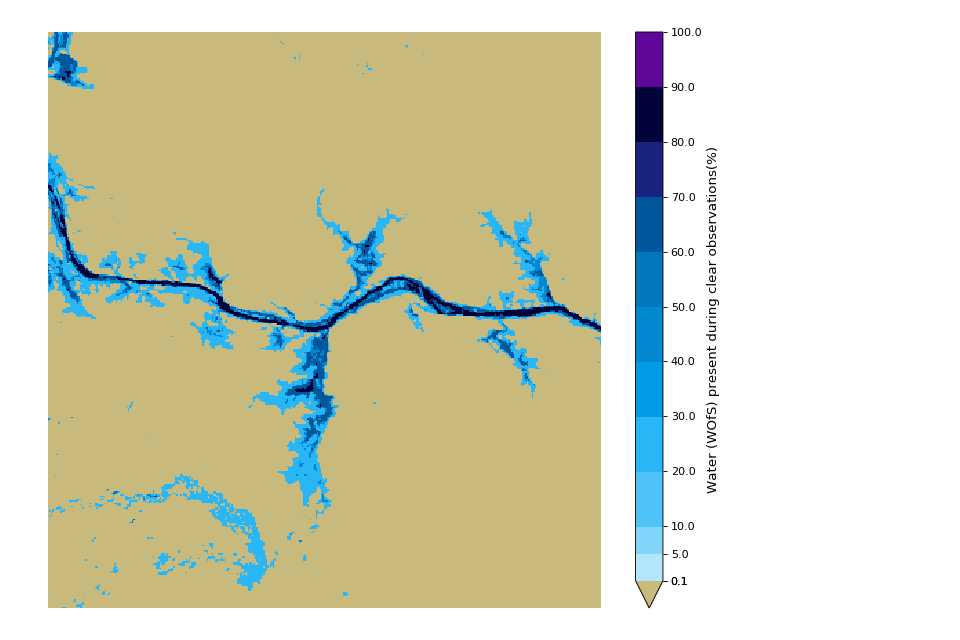

/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/matplotlib/colorbar.py:871: RuntimeWarning: invalid value encountered in true_divide
  z = np.take(y, i0) + (xn - np.take(b, i0)) * dy / db


In [100]:
#
#create widget that enables interaction with plot
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y)
    
fig.canvas.mpl_connect('button_press_event', callback)

fig = plt.figure(figsize =(12,8)) # set figure size
#fig = plt.figure(figsize =(21,21)) # set figure size
i= wofs128_v2.water.plot.imshow(cmap = wofs_cmap,norm=wofs_norm,vmin = 0, vmax = 100)#create plot
fig.delaxes(fig.axes[1]) #remove colour bar
fig.colorbar(i, ticks=wofs_bounds, spacing='proportional', 
             extend='min').set_label(label='Water (WOfS) present during clear observations(%)',
             size=12)
#reformat
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border size
fig.patch.set_facecolor('white') #ensure border is white
fig.patch.set_alpha(0.99)
plt.axis('off')

plt.show()
display(w)

In [66]:
# # #save figure
# %cd /g/data/r78/ext547/Output/wofs/FDC/
# # plt.savefig('FDC_WOfS_scale_small.jpg')
# plt.savefig('FDC_WOfS_all.jpg')

# Examination of overbank flow

In [67]:
#Take the sum pixels of water present at each time slice
wofs_area_ar = wofs128.sum(dim = ['longitude','latitude']) #sum pixels 

In [68]:
#process data to allow the merge of streamflow data with WOfS data
wofs_area_py = wofs_area_ar.to_dataframe() #Convert wofs array into a pandas dataframe
wofs_area_py.index = wofs_area_py.index + pd.Timedelta(hours=10) #Roughly convert to time to local time
wofs_area_py.index = wofs_area_py.index.map(lambda t: t.strftime('%Y-%m-%d')) #Remove Hours/Minutes Seconds by formatting into a string

In [69]:
#reformat date of streamflow data prior to merge
subset_data.date = subset_data.date.map(lambda t: t.strftime('%Y-%m-%d')) #Change datetime format

In [70]:
#Merge streamflow and WOfS dataframe
wofs_area = pd.merge(subset_data, wofs_area_py, left_on= 'date', right_index=True, how='inner') #merge
wofs_area=wofs_area[~wofs_area.index.duplicated(keep='last')]  #drop duplicates from WOfS dataframe (duplicates occur because of how WOfS data was loaded (searching days either side of the satellite pass))
wofs_area = wofs_area.sort_values('perexc', ascending=[True]) #Sort data by percentage exceedance

<IPython.core.display.Javascript object>


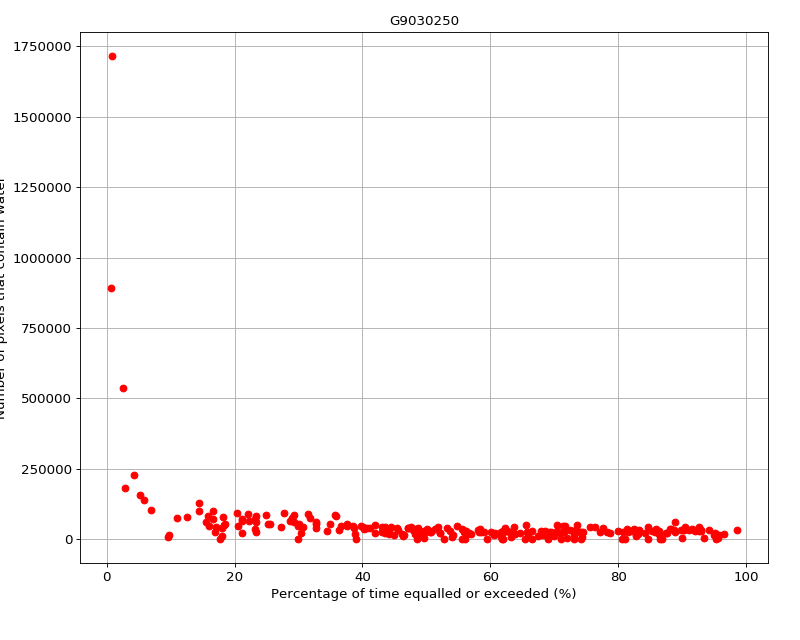

In [71]:
##creation of plot that shows the amount of water pixels for each percentage discharge value

#Plot details
fig = plt.figure(figsize=(10,8)) #Edit size of plot ###User should format as required
plt.title(gauge_of_interest, size=12) #Plot title ###User should format if required
plt.grid(True) #Add gridlines to the figure
plt.subplots_adjust(left=0.10, right=0.96, top=0.95, bottom=0.12) #Set border dimensions  ###User should format if required
fig.patch.set_facecolor('white')  #Make border white ###User should format if required
fig.patch.set_alpha(0.99)  #Make border white ###User should format if required

#create plot of percent exceedance
plt.plot(wofs_area.perexc, wofs_area.water, 'ro')  #plot percentage exceedance vs number of pixels  ###User should format series if required

#axis and legend details
plt.xticks(size=12) #Format size of date labels ###User should format if required
plt.yticks(size=12) #Format size of date labels ###User should format if required
plt.ylabel('Number of pixels that contain water', size=12) #Set Y label
plt.xlabel('Percentage of time equalled or exceeded (%)', size=12) #Set X label

plt.show() #Show plot

In [101]:
# #save figure
%cd /g/data/r78/ext547/Output/wofs/overbank
# plt.savefig('FDC_WOfS_scale_small.jpg')
plt.savefig(gauge_of_interest+'.jpg')

/g/data1/r78/ext547/Output/wofs/overbank
